# Anomalies in Time Series Data

**Lesson Goals**

- Use entropy as a quick way to identify fields that may have anomalies. 

- Use statistical properties to flag the data points that deviate from the expected. 

**The Data**

- Logs of API requests to our data containing sales information about our stores and items. 

- Type of target variable: **Continuous** or Discrete

- Type of observations: **Time Series** or Point in Time   


**The Questions**

- Are there unusual IP addresses accessing our data via the API? 

- Have we seen any spikes or unusual patterns in the size of requests? 

- In general: Does this new value deviate from what we would expect based on historical data? If so, is it something to be concerned about? Remember, we aren't detecting anomalies for the sake of detecting anomalies. 


_____________________________


## Wrangle Data

**Prepare Environment**

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()


**Acquire**

After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly. 

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df = pd.read_csv('https://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

For this research, we are only interested in the IP address, timestamp and size of the requests. 

In [3]:
df = df[['ip', 'timestamp', 'size']]

**Explore IP Address**

In this sample data, it's pretty easy to take a look at value counts to see those IP's that are rare. However, usually the data is much, much larger and looking at simple value counts is not going to be enough. 

In [4]:
# value counts

In [5]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [6]:
# len(df.ip.value_counts())

# value, counts = np.unique(df.ip, return_counts=True)
# ent = entropy(counts, base=None)

In [7]:
compute_entropy(df.ip)

0.5648495339393655

**Prepare Data to Explore Size**

First, we will resample the existing data to 30 minute increments. 

In [8]:
df.head()

,ip,timestamp,size
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],512495
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],3561
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],510103
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],510003
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],511963


In [9]:
# select timestamp
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
df = df.set_index('timestamp')
df = df[['size']].resample('1d').sum()

In [10]:
df = df.fillna(value=0)
df.describe()

,size
count,2.000000e+00
mean,3.143457e+09
std,3.305049e+09
min,8.064345e+08
25%,1.974946e+09
50%,3.143457e+09
75%,4.311968e+09
max,5.480479e+09


**Aside: Simulate some new data to manufacture some anomalies**

Now, let's create a new dataframe that extends our data another year or so. 

In [11]:
new = pd.DataFrame([["[18/Apr/2019:00:00:00+0000]", 0],
                    ["[15/Mar/2020:00:00:00+0000]", 0]], columns=['timestamp','size'])

We will then resample 

In [12]:
new.timestamp = new.timestamp.str.replace(r'(\[|\])', '', regex=True)
new.timestamp = pd.to_datetime(new.timestamp.str.replace(':', ' ', 1))
new = new.set_index('timestamp')
new = new.resample('1d').sum()

In [13]:
new = new.fillna(value=0)
new.tail()

,size
timestamp,
2020-03-11 00:00:00+00:00,0
2020-03-12 00:00:00+00:00,0
2020-03-13 00:00:00+00:00,0
2020-03-14 00:00:00+00:00,0
2020-03-15 00:00:00+00:00,0


In [14]:
# get mean and standard deviation for randomly generating some data. 
mean = df['size'].mean()
std = df['size'].std()

Fill values with random number between `[0, mean+2*standard deviation]`. 

In [15]:
# new['size'] = new['size'].apply(lambda x: max(np.rint(np.random.normal(mean, std)), 0) if x==0 else x)
new['size'] = new['size'].apply(lambda x: np.random.randint(0, mean+2*std) if x==0 else x)

In [16]:
new.describe()

,size
count,3.330000e+02
mean,4.885088e+09
std,2.705123e+09
min,4.369182e+07
25%,2.623592e+09
50%,4.749249e+09
75%,7.020134e+09
max,9.738408e+09


Fill with some anomalies by replacing the zeros that remain with random number between `[(mean+2*std), (mean+5*std)]`

In [17]:
new['size'] = new['size'].apply(lambda x: np.random.randint(mean+5*std, mean+9*std) if x<200000000 else x)

In [18]:
new.describe()

,size
count,3.330000e+02
mean,5.420293e+09
std,4.223319e+09
min,2.778189e+08
25%,2.849604e+09
50%,4.903131e+09
75%,7.147720e+09
max,3.132775e+10


Concatentate our new data with our original data

In [19]:
df = pd.concat([df, new])

(array([103., 125.,  97.,   4.,   0.,   0.,   0.,   0.,   1.,   5.]),
 array([2.77818869e+08, 3.38281207e+09, 6.48780528e+09, 9.59279848e+09,
        1.26977917e+10, 1.58027849e+10, 1.89077781e+10, 2.20127713e+10,
        2.51177645e+10, 2.82227577e+10, 3.13277509e+10]),
 <a list of 10 Patch objects>)

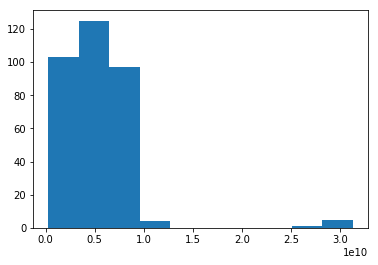

In [20]:
plt.hist(df['size'])

## Explore Size

First, let's represent size in MB for ease of conceptual understanding.  

In [21]:
df['size_mb'] = [n/1024/1024 for n in df['size']]
df = df[['size_mb']]

In [22]:
df.describe()

,size_mb
count,335.000000
mean,5156.230476
std,4022.785757
min,264.948720
25%,2685.435716
50%,4675.990493
75%,6815.986144
max,29876.471437


**Split into Train/Test**

In [23]:
train = df[:'2019-10-17']
validate = df['2019-10-18':'2020-01-15']
test = df['2020-01-16':]

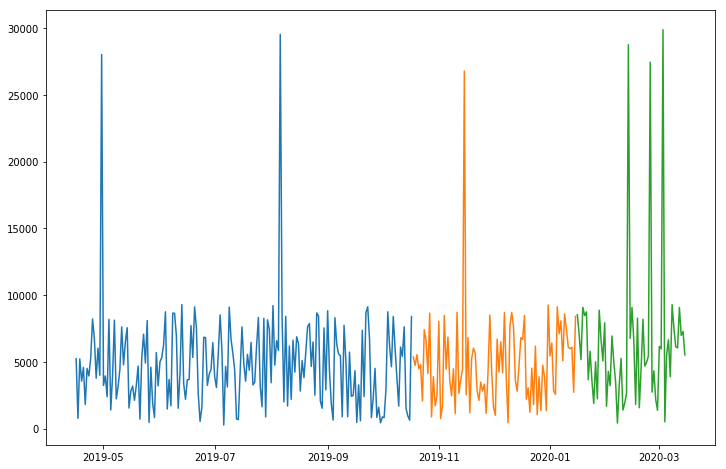

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.show()

## Simple Moving Average

In [25]:
# 1 week
sma_short = train.rolling(window=7).mean()
sma_short[:10]

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,NaN
2019-04-18 00:00:00+00:00,NaN
2019-04-19 00:00:00+00:00,NaN
2019-04-20 00:00:00+00:00,NaN
2019-04-21 00:00:00+00:00,NaN
2019-04-22 00:00:00+00:00,3665.868877
2019-04-23 00:00:00+00:00,3481.849040
2019-04-24 00:00:00+00:00,4127.922946


In [26]:
sma_long = train.rolling(window=30).mean()
sma_long[27:33]

,size_mb
timestamp,
2019-05-13 00:00:00+00:00,NaN
2019-05-14 00:00:00+00:00,NaN
2019-05-15 00:00:00+00:00,5355.105229
2019-05-16 00:00:00+00:00,5274.242291
2019-05-17 00:00:00+00:00,5354.751647
2019-05-18 00:00:00+00:00,5251.383465


**Plot the SMA**

Text(0, 0.5, 'Size (MB)')

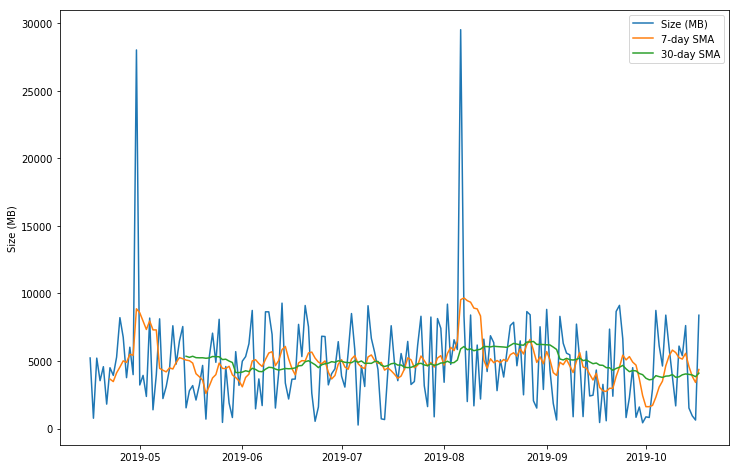

In [28]:

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train, label='Size (MB)')

ax.plot(train.index, sma_short, label = '7-day SMA')

ax.plot(train.index, sma_long, label = '30-day SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

Try some other windows to compare. 

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will use 1 week, which is $24*2*7 = 336$

In [30]:
ema_short = train.ewm(span=7).mean()
ema_short.head()

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,5226.592266
2019-04-17 00:00:00+00:00,2679.440056
2019-04-18 00:00:00+00:00,3776.714323
2019-04-19 00:00:00+00:00,3693.016949
2019-04-20 00:00:00+00:00,3984.674555


In [31]:
ema_long = train.ewm(span=30).mean()
ema_long.tail()

,size_mb
timestamp,
2019-10-13 00:00:00+00:00,4566.913021
2019-10-14 00:00:00+00:00,4370.475316
2019-10-15 00:00:00+00:00,4149.708768
2019-10-16 00:00:00+00:00,3922.785600
2019-10-17 00:00:00+00:00,4211.110604


**Comparison of SMA and EMA**

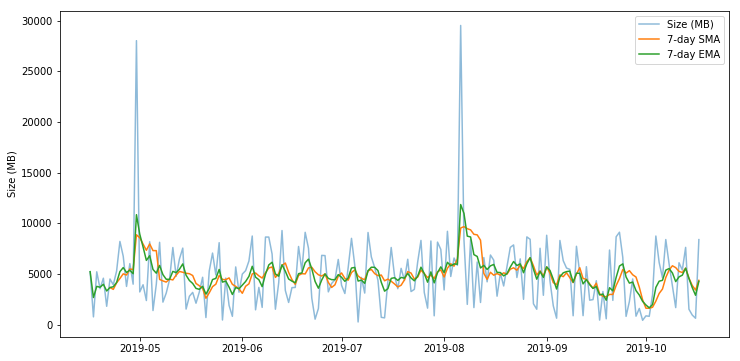

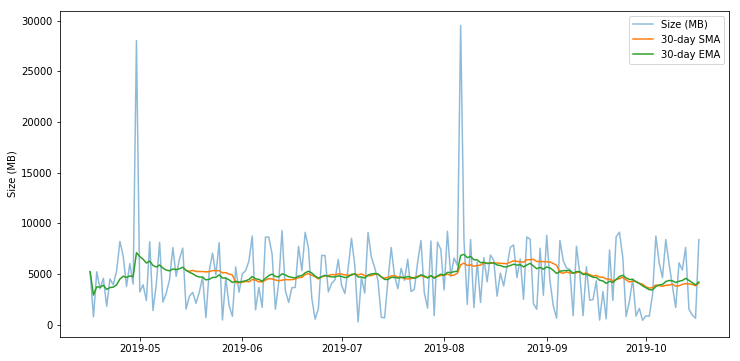

In [32]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_short, label = '7-day SMA')
ax.plot(train.index, ema_short, label = '7-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_long, label = '30-day SMA')
ax.plot(train.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)


## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$


In [33]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()
midband

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,5226.592266
2019-04-17 00:00:00+00:00,2923.542143
2019-04-18 00:00:00+00:00,3739.500756
2019-04-19 00:00:00+00:00,3686.695178
2019-04-20 00:00:00+00:00,3890.580835
...,...
2019-10-13 00:00:00+00:00,4566.913021
2019-10-14 00:00:00+00:00,4370.475316
2019-10-15 00:00:00+00:00,4149.708768


In [34]:
# compute exponential stdev
stdev = train.ewm(span=span).std()
stdev

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,3151.940050
2019-04-18 00:00:00+00:00,2571.516072
2019-04-19 00:00:00+00:00,2066.332570
2019-04-20 00:00:00+00:00,1808.334421
...,...
2019-10-13 00:00:00+00:00,2831.106674
2019-10-14 00:00:00+00:00,2841.983129
2019-10-15 00:00:00+00:00,2878.687447


In [36]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

ub

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,12379.362294
2019-04-18 00:00:00+00:00,11454.048970
2019-04-19 00:00:00+00:00,9885.692888
2019-04-20 00:00:00+00:00,9315.584100
...,...
2019-10-13 00:00:00+00:00,13060.233042
2019-10-14 00:00:00+00:00,12896.424701
2019-10-15 00:00:00+00:00,12785.771109


Plot the bands

Text(0, 0.5, 'Size (MB)')

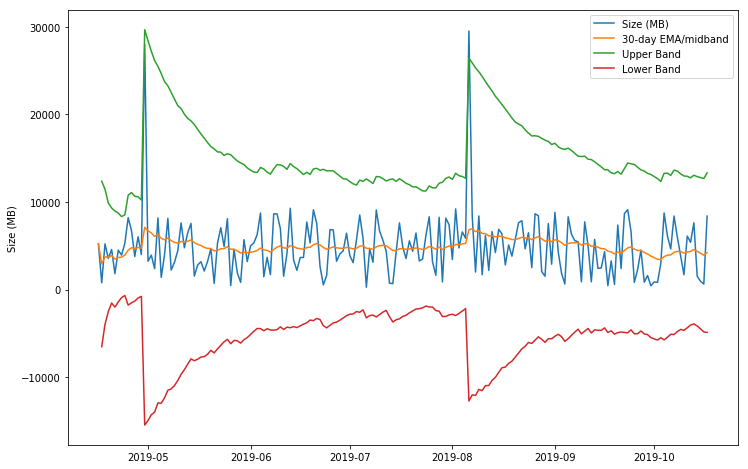

In [37]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(train.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(train.index, 
        ub, 
        label = 'Upper Band')
ax.plot(train.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

Where do you think we will have a %b > 1? 

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

In [38]:
train = pd.concat([train, midband, ub, lb], axis=1)
train.columns = ['size_mb', 'midband', 'ub', 'lb']
train.tail()

,size_mb,midband,ub,lb
timestamp,,,,
2019-10-13 00:00:00+00:00,7626.163160,4566.913021,13060.233042,-3926.407000
2019-10-14 00:00:00+00:00,1522.144887,4370.475316,12896.424701,-4155.474070
2019-10-15 00:00:00+00:00,948.610957,4149.708768,12785.771109,-4486.353574
2019-10-16 00:00:00+00:00,632.416145,3922.785600,12681.867086,-4836.295886
2019-10-17 00:00:00+00:00,8391.803582,4211.110604,13321.236178,-4899.014969


In [39]:
(7626 - (-3926.4))/(13060-(-3926))

0.6801130342635111

In [40]:
train['pct_b'] = (train['size_mb'] - train['lb'])/(train['ub'] - train['lb'])

In [42]:
train[train['pct_b']>1]

,size_mb,midband,ub,lb,pct_b
timestamp,,,,,
2019-08-06 00:00:00+00:00,29525.368535,6834.27831,26396.427461,-12727.870841,1.079974


## Exercises

**file name:** time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

Can you label students who are viewing both the web dev and data science curriculum?
Can you label students by the program they are in? 
Can you label users by student vs. staff?
What are Zach, Maggie, Faith, and Ryan's ids?